# Change Coordinate Reference System

Converting from EPSG:9001 to EPSG:4326, which represents spatial coordinates in terms of latitude and longitude based on the World Geodetic System 1984 (WGS84).

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show


In [2]:
# Read metadata of raster map
raster_path = '../datasets/rainfall/nws_precip_1day_20190515_conus.tif'
raster = rasterio.open(raster_path)
raster.meta


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1121,
 'height': 881,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(4763.0, 0.0, -1904912.11073866,
        0.0, -4763.0, -3423783.69569394)}

## Save raster with new CRS in a separate file

In [3]:
# Set properties to be used in the new reprojected raster map
new_crs = 'EPSG:4326' # As an alternative the EPSG:3857 represents the web meractor 
transform, width, height = calculate_default_transform(raster.crs,new_crs,raster.width,raster.height,*raster.bounds)
kwargs = raster.meta.copy()
kwargs.update({'crs':new_crs, 'transform':transform, 'width':width, 'height':height})


In [4]:
# Iterate over each band and reproject
# This step will save a new reprojected .tiff file
new_filename = "../datasets/rainfall/nws_precip_1day_20190515_conus_latlon.tif"
with rasterio.open(new_filename, 'w', **kwargs) as dst:
    for i in range(1, raster.count + 1):
        reproject(
            source = rasterio.band(raster, i),
            destination = rasterio.band(dst, i),
            src_transform = raster.transform,
            src_crs = raster.crs,
            dst_transform = transform,
            dst_crs = new_crs,
            resampling = Resampling.nearest)
        

In [5]:
# Load newly created and reprojected .tiff file and display the new metadata
# to check that we did the right CRS conversion
raster_reprojected = rasterio.open(new_filename)
print(raster_reprojected.meta)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1675, 'height': 860, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.044273720114906476, 0.0, -134.09052600184998,
       0.0, -0.044273720114906476, 57.86725177915063)}


## Overwrite file with new CRS

Here is an exploratory alternative that can do everything without creating a separate file. It needs some fine tunning, but I decided to post this here in Markdown to prevent conflict with the preceding cells.

```python
# Change CRS in existing raster variable
raster_reprojected = raster
with rasterio.open(raster_path, 'r+', **kwargs) as raster:
    for i in range(1, raster.count + 1):
        reproject(
            source = rasterio.band(raster, i),
            destination = rasterio.band(raster, i),
            src_transform = raster.transform,
            src_crs = raster.crs,
            dst_transform = transform,
            dst_crs = new_crs,
            resampling = Resampling.nearest)
        
raster = rasterio.open(raster_path)

# Check new coordinate referece system
print(raster.meta)

```

## Generate matrices of latitude and longitude

Often times we need to gain access to the entire matrix of latitude and longitude values, say to determine the pixel nearest to a point of interest.

In [6]:
# Generate grid of rows and columns
y_vector = np.arange(raster_reprojected.shape[0]) # y is latitude
x_vector = np.arange(raster_reprojected.shape[1]) # x is longitude
[X,Y] = np.meshgrid(x_vector, y_vector)

print(raster_reprojected.shape)
print(X.shape)
print(Y.shape)

(860, 1675)
(860, 1675)
(860, 1675)


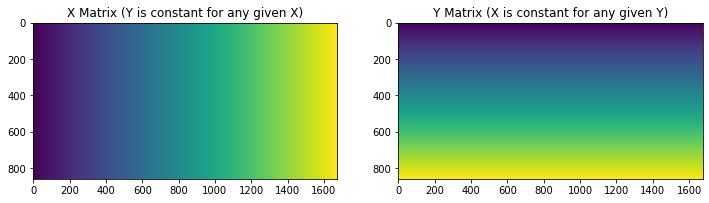

In [7]:
# Plot gradients to check our computations.
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('X Matrix (Y is constant for any given X)')
plt.imshow(X)

plt.subplot(1,2,2)
plt.title('Y Matrix (X is constant for any given Y)')
plt.imshow(Y)

plt.show()

In [8]:
print('Xmin:',X[0,0],'Xmax:',X[-1,-1])
print('Ymin:',Y[0,0],'Ymax:',Y[-1,-1])

Xmin: 0 Xmax: 1674
Ymin: 0 Ymax: 859


## Matching X,Y to Lat,Lon

This part can be tricky since X is Lon and Y is Lat. Here I suggest devising a way to test that we get the right results for the corners, and then we proceed to pass the matrices of Xs and Ys. This will save us countless hours of debugging and a headache down the road.

In [9]:
# First the bounds from the raster we want to match
# Our corners using X and Y need to match these value or else the conversion is wrong.
raster_reprojected.bounds


BoundingBox(left=-134.09052600184998, bottom=19.79185248033106, right=-59.93204480938164, top=57.86725177915063)

In [10]:
# This gives us the correct upper-right corner
print(raster_reprojected.xy(0,0,'ul'))


(-134.09052600184998, 57.86725177915063)


In [11]:
# This gives us the correct lower-right corner
print(raster_reprojected.xy(859,1674,'lr'))


(-59.93204480938162, 19.79185248033106)


Passing the `X` and `Y` matrices into rasterio `xy()` method would result in a tuple with nested arrays that are a bit more difficult to work with. So, to keep things simple, we can `flatten` the input arrays and then `reshape` the resulting arrays to amtch the dimension of the raster image. Sometimes is worth doing a little exploration on the output format and ensure variables are in a format that we feel comfortable working with. 

In [12]:
# This part may take few seconds
lon_vector,lat_vector = raster_reprojected.xy(Y.flatten(), X.flatten())


In [13]:
lon_grid = np.reshape(lon_vector , X.shape)
lat_grid = np.reshape(lat_vector , Y.shape)

In [14]:
# Check resulting matrix dimensions
print('Latitude:', lat_grid.shape)
print('Longitude:', lon_grid.shape)


Latitude: (860, 1675)
Longitude: (860, 1675)


In [15]:
# Check corners of matrix (in clockwise order)
print('UL (Northwest corner) => Lat:', lat_grid[[0],[0]], 'Lon:', lon_grid[[0],[0]])
print('UR (Northeast corner) => Lat:', lat_grid[[0],[0]], 'Lon:', lon_grid[[-1],[-1]])
print('LR (Southeast corner) => Lat:', lat_grid[[-1],[-1]], 'Lon:', lon_grid[[-1],[-1]])
print('LL (Southwest corner) => Lat:', lat_grid[[-1],[-1]], 'Lon:', lon_grid[[0],[0]])


UL (Northwest corner) => Lat: [57.84511492] Lon: [-134.06838914]
UR (Northeast corner) => Lat: [57.84511492] Lon: [-59.95418167]
LR (Southeast corner) => Lat: [19.81398934] Lon: [-59.95418167]
LL (Southwest corner) => Lat: [19.81398934] Lon: [-134.06838914]


In [16]:
def haversine(lat_point,lon_point,lat_list, lon_list):

    """Haversine function: Computes distance between the geogrpahic
    coordinates of two points on a sphere or a point and list of points.

    Inputs: geographic coordinates in decimal degrees.
    Output: Approximate distance in kilometers"""

   # Convert point coordinates to radians
    lat_point = np.radians(lat_point)
    lon_point = np.radians(lon_point)

    # Convert list coordinates to radians
    lat_list = np.radians(lat_list)
    lon_list = np.radians(lon_list)

    # Compute deltas to simplify equation below
    lat_delta = lat_list - lat_point
    lon_delta = lon_list - lon_point

    # Define average Earth radius in kilometers
    earth_radius = 6367 # kilometers

    # Haversine formula
    a = (np.sin(lat_delta/2))**2 + np.cos(lat_point) * np.cos(lat_list) * (np.sin(lon_delta/2))**2
    a[a>1] = 1
    a[a<0] = 0
    d = 2 * earth_radius * np.arcsin(np.sqrt(a))
    return d


Shape of distance matrix D: (860, 1675)
Row and Column of nearest pixel: (493, 318)


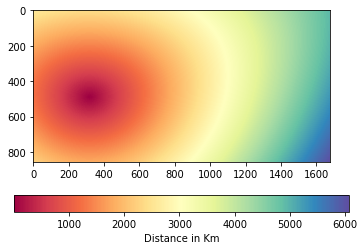

In [30]:
# Define coordinates for a point of interest
POI_lat = 36
POI_lon = -120

# Compute distance from POI to all pixels
D = haversine(POI_lat, POI_lon, lat_grid, lon_grid)
print('Shape of distance matrix D:', D.shape)

# Find nearest pixel to POI
idx_nearest = np.unravel_index(np.argmin(D, axis=None), D.shape)
print('Row and Column of nearest pixel:',idx_nearest)

# Create plot of distances
plt.imshow(D, cmap='Spectral')
plt.colorbar(orientation="horizontal", label="Distance in Km")
plt.show()


In the cell above you can change the coordinates of the POI for any place in the United States to see how the intensity of the distance matrix changes.

## Convert Lat,Lon to X,Y

A quick option to change from from geogrpahic to projected coordinates is to use the PyProj library.

In [2]:
from pyproj import Proj
POI_lat = 36
POI_lon = -120

pp = Proj(proj='utm',zone=14,ellps='WGS84', preserve_units=False)
#x,y = pp(df['longitude'].values,df['latitude'].values)
x,y = pp(POI_lon, POI_lat)
print(x,y)

-1405334.8530004257 4194697.664163701
